# LLM Usability: IRR Statistical Analysis
**Authors** 
- Nolan Platt (nolanplatt@vt.edu) 
- Ethan Luchs (ethanluchs@vt.edu) 
- Dr. Sehrish Basir Nizamani (sehrishbasir@vt.edu) 

**Date:** 5/3/2025

## 1. Import libraries

In [421]:
import os, json
import pandas as pd
from glob import glob

# IRR metrics
from sklearn.metrics import cohen_kappa_score
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa

# Visualization
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', 50)

## 2. Load JSON data

In [422]:
def load_results(path="results"):
    rows = []
    for repo in sorted(os.listdir(path)):
        repo_dir = os.path.join(path, repo)
        if not os.path.isdir(repo_dir):
            continue
        for fn in sorted(glob(f"{repo_dir}/eval*.json")):
            evaln = os.path.splitext(fn)[0].split(os.sep)[-1]
            for rec in json.load(open(fn)):
                rec.update(repo=repo, eval=evaln)
                rows.append(rec)
    return pd.DataFrame(rows)

df = load_results("results")

## 3. Severity Rating Distribution
Plots distribution of severity ratings for all records.

 Severity  Count
        0    164
        1    251
        2    306
        3    155
        4      9


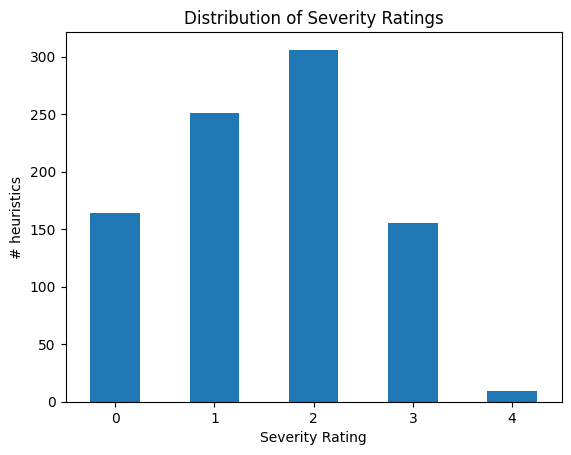

\begin{tabular}{rr}
\toprule
Severity & Count \\
\midrule
0 & 164 \\
1 & 251 \\
2 & 306 \\
3 & 155 \\
4 & 9 \\
\bottomrule
\end{tabular}



In [431]:
dist = df['SeverityRating'].value_counts().sort_index()
dist_df = dist.rename_axis('Severity').reset_index(name='Count')
print(dist_df.to_string(index=False))

# plot
dist.plot.bar(x='Severity', y='Count', legend=False, rot =0)
plt.title('Distribution of Severity Ratings')
plt.xlabel('Severity Rating')
plt.ylabel('# heuristics')
plt.show()
print(dist_df.to_latex(index=False))



## 4. Issue  Distribution
Plots distribution of issues found for all records.

 IssueFound  Count
      False    165
       True    720


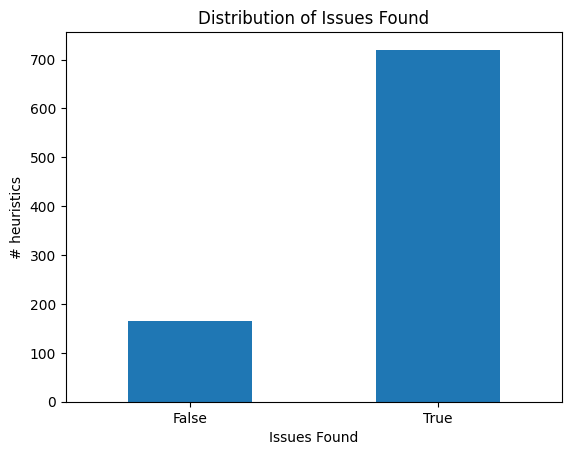

\begin{tabular}{rr}
\toprule
IssueFound & Count \\
\midrule
False & 165 \\
True & 720 \\
\bottomrule
\end{tabular}



In [440]:
dist = df['IssueFound'].value_counts().sort_index()
dist_df = dist.rename_axis('IssueFound').reset_index(name='Count')
print(dist_df.to_string(index=False))

# plot
dist.plot.bar(x='IssueFound', y='Count', legend=False, rot =0)
plt.title('Distribution of Issues Found')
plt.xlabel('Issues Found')
plt.ylabel('# heuristics')
plt.show()
print(dist_df.to_latex(index=False))


## 5. Normalize data
For some evaluations, the name of heuristics slightly differed (i.e. included heuristic numbering #) contained duplicates, or had whitespaces

In [441]:
mapping = {
    r'^\d+\.\s*': '',
}
df['Heuristic'] = (
    df['Heuristic']
    .str.strip()
    .str.replace(r'^\d+\.\s*', '', regex=True)
    .str.title()
)
#  set canonical list that ALL heuristics should map to
canonical = [
    'Visibility Of System Status',
    'Match Between System And The Real World',
    'User Control And Freedom',
    'Consistency And Standards',
    'Error Prevention',
    'Recognition Rather Than Recall',
    'Flexibility And Efficiency Of Use',
    'Aesthetic And Minimalist Design',
    'Help Users Recognize, Diagnose, And Recover From Errors',
    'Help And Documentation'
]
df = df[df['Heuristic'].isin(canonical)]

# normalize all heuristics and remove duplicates or whitespaces
df['eval'] = df['eval'].str.replace(r'\s+', '', regex=True)
df = df[df['eval'].isin(['eval1','eval2','eval3'])]
df = df.drop_duplicates(subset=['repo','Heuristic','eval'])


## 6. Pivot
Builds 300x3 pivots for severity ratings & issues found

In [442]:
sites = sorted(df['repo'].unique())
heuristics = sorted(df['Heuristic'].unique())
full_idx = pd.MultiIndex.from_product([sites, heuristics], names=['repo','Heuristic'])

# pivot severities
severity_pivot = (
    df.pivot_table(
        index=['repo','Heuristic'],
        columns='eval',
        values='SeverityRating',
        aggfunc='first',
        fill_value=0
    )
    .reindex(full_idx, fill_value=0)[['eval1','eval2','eval3']]
)

# pivot issues found
issue_pivot = (
    df.pivot_table(
        index=['repo','Heuristic'],
        columns='eval',
        values='IssueFound',
        aggfunc='max',
        fill_value=False
    )
    .reindex(full_idx, fill_value=False)[['eval1','eval2','eval3']]
    .astype(int)
)


## 7. IRR: Severity Ratings
Computes the  weighted Cohen's Kappa (κ) for all severity ratings for all sites.

In [443]:
irr_rows = []
pairs = [('eval1','eval2'), ('eval1','eval3'), ('eval2','eval3')]

for a, b in pairs:
    sub = severity_pivot[[a, b]].dropna().astype(int)
    tot = len(sub)
    eq  = (sub[a] == sub[b]).sum()
    pct = eq / tot * 100
    k   = cohen(sub[a], sub[b])
    irr_rows.append({
        'Pair':       f'{a}-{b}',
        'Weighted κ': k,
        'Agreement':  f'{eq}/{tot}',
        'Exact %':    pct
    })

severity_irr_df = pd.DataFrame(irr_rows)
display(severity_irr_df)

# for LaTeX purposes
print(
    severity_irr_df.to_latex(
        index=False,
        escape=False,  # allow LaTeX macros
        header=[
            'Pair',
            r'Weighted $\kappa$',
            'Agreement',
            r'Exact \%'
        ],
        formatters={
            'Weighted κ': lambda x: f"{x:.3f}",
            'Agreement':  lambda s: s,
            'Exact %':    lambda x: f"{x:.1f}\\%"
        }
    )
)


,Pair,Weighted κ,Agreement,Exact %
0,eval1-eval2,0.625361,169/300,56.333333
1,eval1-eval3,0.668431,171/300,57.000000
2,eval2-eval3,0.596722,167/300,55.666667


\begin{tabular}{lrlr}
\toprule
Pair & Weighted $\kappa$ & Agreement & Exact \% \\
\midrule
eval1-eval2 & 0.625 & 169/300 & 56.3\% \\
eval1-eval3 & 0.668 & 171/300 & 57.0\% \\
eval2-eval3 & 0.597 & 167/300 & 55.7\% \\
\bottomrule
\end{tabular}



## 8. Compute Per-Site Severity IRR 
Computes paired weighted Cohen's Kappa for each of the 30 sites. 

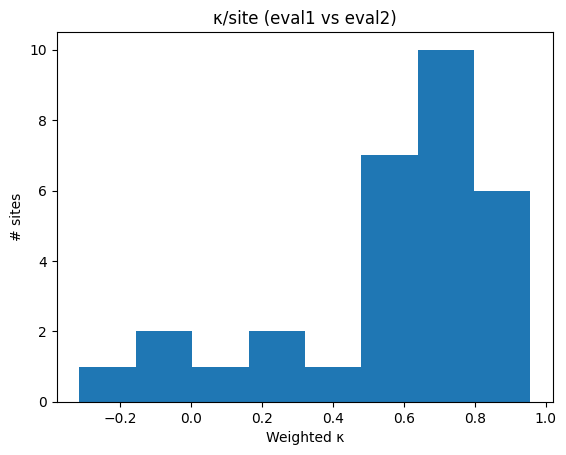

In [457]:
site_stats = []
for repo in sites:
    mat = severity_pivot.xs(repo, level='repo').astype(int)
    k12 = cohen(mat['eval1'], mat['eval2']) # weighted k between eval1 & eval2
    k13 = cohen(mat['eval1'], mat['eval3']) # weighted k between eval1 & eval3
    k23 = cohen(mat['eval2'], mat['eval3']) # weighted k between eval2 & eval3
    site_stats.append({'repo': repo, 'κ12': k12, 'κ13': k13, 'κ23': k23})
site_df = pd.DataFrame(site_stats)


#display(site_df)
#print(site_df.to_latex(index=False))

plt.hist(site_df['κ12'], bins=8)
plt.title('κ/site (eval1 vs eval2)')
plt.xlabel('Weighted κ')
plt.ylabel('# sites')
plt.show()

## 9. Compute Per-Heuristic Severity IRR
Computes paired weighted Cohen's Kappa for each of the 10 heuristics.

In [458]:

heur_stats = []
for h in heuristics:
    mat = severity_pivot.xs(h, level='Heuristic').astype(int)
    k12 = cohen(mat['eval1'], mat['eval2']) # weighted k between eval1 & eval2
    k13 = cohen(mat['eval1'], mat['eval3']) # weighted k between eval1 & eval3
    k23 = cohen(mat['eval2'], mat['eval3']) # weighted k between eval2 & eval3
    heur_stats.append({'Heuristic': h, 'κ (1-2)': k12, 'κ (1-3)': k13, 'κ (2-3)': k23})
heur_df = pd.DataFrame(heur_stats)

display(heur_df)
print(heur_df.to_latex(index=False))


,Heuristic,κ (1-2),κ (1-3),κ (2-3)
0,Aesthetic And Minimalist Design,0.328358,0.142857,0.153846
1,Consistency And Standards,-0.024390,0.302326,-0.028571
2,Error Prevention,0.416216,0.550898,0.437727
3,Flexibility And Efficiency Of Use,0.103448,0.280000,0.032258
4,Help And Documentation,-0.068111,0.123223,0.188482
5,"Help Users Recognize, Diagnose, And Recover Fr...",0.405797,0.291785,0.231156
6,Match Between System And The Real World,0.569378,0.363636,0.266667
7,Recognition Rather Than Recall,0.237875,0.210526,0.132231
8,User Control And Freedom,0.327103,0.533981,-0.010101
9,Visibility Of System Status,0.426752,0.297872,0.251627


\begin{tabular}{lrrr}
\toprule
Heuristic & κ (1-2) & κ (1-3) & κ (2-3) \\
\midrule
Aesthetic And Minimalist Design & 0.328358 & 0.142857 & 0.153846 \\
Consistency And Standards & -0.024390 & 0.302326 & -0.028571 \\
Error Prevention & 0.416216 & 0.550898 & 0.437727 \\
Flexibility And Efficiency Of Use & 0.103448 & 0.280000 & 0.032258 \\
Help And Documentation & -0.068111 & 0.123223 & 0.188482 \\
Help Users Recognize, Diagnose, And Recover From Errors & 0.405797 & 0.291785 & 0.231156 \\
Match Between System And The Real World & 0.569378 & 0.363636 & 0.266667 \\
Recognition Rather Than Recall & 0.237875 & 0.210526 & 0.132231 \\
User Control And Freedom & 0.327103 & 0.533981 & -0.010101 \\
Visibility Of System Status & 0.426752 & 0.297872 & 0.251627 \\
\bottomrule
\end{tabular}



## 10. Compute Binary IRR for Issues

In [459]:

# pairwise Cohen'S Kappa
irr_rows = []
pairs = [('eval1','eval2'), ('eval1','eval3'), ('eval2','eval3')]

for a, b in pairs:
    sub = issue_pivot[[a, b]]
    tot = len(sub)
    eq  = (sub[a] == sub[b]).sum()
    pct = eq / tot * 100
    k   = cohen_kappa_score(sub[a], sub[b])
    irr_rows.append({
        'Pair':     f'{a}-{b}',
        'Weighted κ': k,
        'Agreement': f'{eq}/{tot}',
        'Exact %':   pct
    })

issue_irr_df = pd.DataFrame(irr_rows)
display(issue_irr_df)

# LaTeX
print(
    issue_irr_df.to_latex(
        index=False,
        escape=False,
        header=[
            'Pair',
            r'$\kappa$',
            'Agreement',
            r'Exact \%'
        ],
        formatters={
            'Weighted κ':  lambda x: f"{x:.3f}",
            'Agreement': lambda s: s,
            'Exact %':   lambda x: f"{x:.1f}\\%"
        }
    )
)

# Compute Krippendorf's Alpha &  Fleiss' Kappa
alpha_bin = krippendorff.alpha(issue_pivot.values,
                               level_of_measurement='nominal')
cnts      = np.stack([(issue_pivot == i).sum(axis=1) for i in [0,1]], axis=1)
fleiss_k  = fleiss_kappa(cnts)

# put into table
multi_df = pd.DataFrame([
    {'Metric': r'Krippendorff $\alpha$', 'Value': alpha_bin},
    {'Metric': r'Fleiss $\kappa$',         'Value': fleiss_k}
])
display(multi_df)

# LaTeX
print(
    multi_df.to_latex(
        index=False,
        escape=False,
        header=['Metric','Value'],
        formatters={'Value': lambda x: f"{x:.3f}"}
    )
)


,Pair,Weighted κ,Agreement,Exact %
0,eval1-eval2,0.470847,247/300,82.333333
1,eval1-eval3,0.529682,255/300,85.000000
2,eval2-eval3,0.502416,254/300,84.666667


\begin{tabular}{lrlr}
\toprule
Pair & $\kappa$ & Agreement & Exact \% \\
\midrule
eval1-eval2 & 0.471 & 247/300 & 82.3\% \\
eval1-eval3 & 0.530 & 255/300 & 85.0\% \\
eval2-eval3 & 0.502 & 254/300 & 84.7\% \\
\bottomrule
\end{tabular}



,Metric,Value
0,Krippendorff $\alpha$,-0.000234
1,Fleiss $\kappa$,0.500000


\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Krippendorff $\alpha$ & -0.000 \\
Fleiss $\kappa$ & 0.500 \\
\bottomrule
\end{tabular}

